# Transformer NER baseline [lb 0.854]

The following is a basic script to train and run inference using `transformers` using 2x T4 GPUs. You might get better performance if you use a bigger model, or one that has already been trained on NER.

It includes processing to correctly map the given tokens with labels during training and vice versa when running inference.


Update: Thanks to @takanashihumbert, I switched `tokens` for `token_map` which helped improve the score from 0.569 to 0.854!


deberta-v3-small: lb 0.576  
deberta-v3-base: lb 0.569 (before update) --> 0.854 (after update) 

In [68]:
TRAINING = False # be sure to turn internet off if doing inference

TRAINING_MODEL_PATH = "microsoft/deberta-v3-large"
TRAINING_MAX_LENGTH = 512



 #   !pip install seqeval evaluate -q
 #   !pip install -U datasets accelerate transformers -q

In [69]:

import json

data = json.load(open("data/train.json"))

print(len(data))
print(data[0].keys())

x = data[0]

print(x["tokens"][:10])
print(x["labels"][:10])
print(x["trailing_whitespace"][:10])

6807
dict_keys(['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'])
['Design', 'Thinking', 'for', 'innovation', 'reflexion', '-', 'Avril', '2021', '-', 'Nathalie']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME_STUDENT']
[True, True, True, True, False, False, True, False, False, True]


In [70]:

from itertools import chain

all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}

id2label

{0: 'B-EMAIL',
 1: 'B-ID_NUM',
 2: 'B-NAME_STUDENT',
 3: 'B-PHONE_NUM',
 4: 'B-STREET_ADDRESS',
 5: 'B-URL_PERSONAL',
 6: 'B-USERNAME',
 7: 'I-ID_NUM',
 8: 'I-NAME_STUDENT',
 9: 'I-PHONE_NUM',
 10: 'I-STREET_ADDRESS',
 11: 'I-URL_PERSONAL',
 12: 'O'}

In [71]:
from datasets import Dataset

ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [x["document"] for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})

In [89]:

from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(TRAINING_MODEL_PATH)

def tokenize(example, tokenizer, label2id):
    text = []
    labels = []
    for single_token, single_label, single_whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
        text.append(single_token)
        labels.extend([single_label]*len(single_token))
        if single_whitespace:
            text.append(" ")
            labels.append("O")

    tokenized = tokenizer("".join(text), return_offsets_mapping=True, truncation=False)

    labels = np.array(labels)

    text = "".join(text)
    token_labels = []

    for start_idx, end_idx in tokenized.offset_mapping:

        # CLS token
        if start_idx + end_idx == 0: 
            token_labels.append(label2id["O"])
            continue

        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1
        
        while start_idx >= len(labels):
            start_idx -= 1

        token_labels.append(label2id[labels[start_idx]])

    length = len(tokenized.input_ids)

    return {
        **tokenized,
        "labels": token_labels,
        "length": length
    }

#id=0
#for entry in ds:
#    if entry['document'] == 13315:
#        print(id)
#        break
#    id+=1

sample = ds[2790]
sample_tokenized=tokenize(sample, tokenizer, label2id)

# create text of sample_tokenized

text = tokenizer.decode(sample_tokenized["input_ids"])

print("original: [CLS] " + sample["full_text"].replace("\n", " "))
print("tokenize: " + text)
print("labels: " + " ".join([id2label[x] for x in sample_tokenized["labels"]]))

# tokenizer.convert_ids_to_tokens(sample_tokenized["input_ids"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


original: [CLS] Design Thinking for Innovation  Reflection  1. Challenge: To expand the distribution of Indian Sindhi papad, globally, to the areas  where the Indian diaspora lives.  A papad basically is a crisp, round flatbread from India. It is typically based on a  seasoned dough usually made from peeled black gram flour, either fried or cooked  with dry heat. And Sindhis are an ethno-linguistic group who speak the Sindhi  language. After the partition of India, most of them migrated to other parts of the  world. And Sindhi papad has a unique taste of its own. But it is usually restricted to  some of the Indian cities itself. Not everyone has the access to have the food items  in their households, especially those who stay thousands of kilometres away from  India.  2. Selection: The tool I’ve selected is Learning Launch. I selected it for the challenge  because I’ve never approached this idea much in the exercises. Also, I mostly liked the  approach of having an initial ‘hypothesis’

['[CLS]',
 '▁Design',
 '▁Thinking',
 '▁for',
 '▁Innovation',
 '▁Reflection',
 '▁1',
 '.',
 '▁Challenge',
 ':',
 '▁To',
 '▁expand',
 '▁the',
 '▁distribution',
 '▁of',
 '▁Indian',
 '▁Sindhi',
 '▁papa',
 'd',
 ',',
 '▁globally',
 ',',
 '▁to',
 '▁the',
 '▁areas',
 '▁where',
 '▁the',
 '▁Indian',
 '▁diaspora',
 '▁lives',
 '.',
 '▁A',
 '▁papa',
 'd',
 '▁basically',
 '▁is',
 '▁a',
 '▁crisp',
 ',',
 '▁round',
 '▁flatbread',
 '▁from',
 '▁India',
 '.',
 '▁It',
 '▁is',
 '▁typically',
 '▁based',
 '▁on',
 '▁a',
 '▁seasoned',
 '▁dough',
 '▁usually',
 '▁made',
 '▁from',
 '▁peeled',
 '▁black',
 '▁gram',
 '▁flour',
 ',',
 '▁either',
 '▁fried',
 '▁or',
 '▁cooked',
 '▁with',
 '▁dry',
 '▁heat',
 '.',
 '▁And',
 '▁Sindhi',
 's',
 '▁are',
 '▁an',
 '▁ethno',
 '-',
 'linguistic',
 '▁group',
 '▁who',
 '▁speak',
 '▁the',
 '▁Sindhi',
 '▁language',
 '.',
 '▁After',
 '▁the',
 '▁partition',
 '▁of',
 '▁India',
 ',',
 '▁most',
 '▁of',
 '▁them',
 '▁migrated',
 '▁to',
 '▁other',
 '▁parts',
 '▁of',
 '▁the',
 '▁world',
 '.

In [73]:



ds = ds.map(lambda x: tokenize(x, tokenizer, label2id), num_proc=12)

Map (num_proc=12):   0%|          | 0/6807 [00:00<?, ? examples/s]

In [74]:
for key in ds[0].keys():
    print(key, " ---> ", ds[0][key])

full_text  --->  Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla

Challenge & selection

The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.

What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1

This tool has many advantages:

•  It is accessible to all and does not require significant material investment and can be done  quickly

•  It is scalable

•  It allows categorization and linking of information

•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas

•  It is suitable for all people and is easy to learn

•  It is fun and encourages exchanges

•  It makes visible th

In [75]:
# Confirm that alignment is good

# run multiple times to see different rows

for i in range(10):
    x = ds.shuffle()[0]
    print(x["document"])

    for single_token,single_label in zip(x["tokens"], x["provided_labels"]):
        if single_label != "O":
            print((single_token,single_label))

    print("*"*100)
            
    for single_token, single_label in zip(tokenizer.convert_ids_to_tokens(x["input_ids"]), x["labels"]):
        if id2label[single_label] != "O":
            print((single_token,id2label[single_label]))

8251
('Kenichi', 'B-NAME_STUDENT')
('Watanabe', 'I-NAME_STUDENT')
****************************************************************************************************
('▁Ken', 'B-NAME_STUDENT')
('ichi', 'B-NAME_STUDENT')
('▁Watanabe', 'I-NAME_STUDENT')
4951
('Norma', 'B-NAME_STUDENT')
('Valenzuela', 'I-NAME_STUDENT')
('Norma', 'B-NAME_STUDENT')
('Valenzuela', 'I-NAME_STUDENT')
****************************************************************************************************
('▁Norma', 'B-NAME_STUDENT')
('▁Valenzuela', 'I-NAME_STUDENT')
('▁Norma', 'B-NAME_STUDENT')
('▁Valenzuela', 'I-NAME_STUDENT')
20629
****************************************************************************************************
8865
****************************************************************************************************
13315
('https://alvarado.com/categoriesindex.html', 'B-URL_PERSONAL')
****************************************************************************************************
('▁https'

## There are some long ones that will get truncated when training if you use a typical max_length

There might be some key labels that are at the end that are being missed.

(array([  9.,  19.,  29.,  50.,  56.,  61.,  83., 104., 147., 165., 190.,
        209., 262., 271., 311., 302., 317., 299., 307., 342., 320., 294.,
        275., 241., 214., 223., 210., 167., 175., 180., 109., 116.,  84.,
         81.,  58.,  57.,  67.,  51.,  50.,  41.,  27.,  32.,  36.,  14.,
         27.,  13.,  11.,   9.,   5.,  13.,  10.,   9.,   8.,   1.,   5.,
          2.,   6.,   3.,   5.,   1.,   2.,   2.,   2.,   0.,   2.,   2.,
          2.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([  67.  ,   97.09,  127.18,  157.27,  187.36,  217.45,  247.54,
         277.63,  307.72,  337.81,  367.9 ,  397.99,  428.08,  458.17,
         488.26,  518.35,  548.44,  578.53,  608.62,  638.71,  668.8 ,
         698.89,  728.98,  759.07,  789.16,  819.25,  849.34,  879.43,
         909.52,  939.61,  969.7 ,

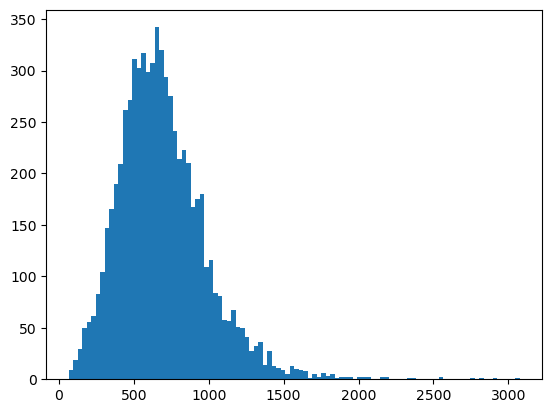

In [90]:

import matplotlib.pyplot as plt


plt.hist(ds["length"], bins=100)

In [91]:

import pandas as pd
import plotly.express as px
from collections import Counter


group = []
labels = []

group_thresholds = [0, 50, 100, 200, 500, 1000, 2000, 10000]

for sample_labels in ds["provided_labels"]:
    for i, label in enumerate(sample_labels):
        if label != "O":
            for j in range(1, len(group_thresholds)):
                lower = group_thresholds[j-1]
                upper = group_thresholds[j]
                
                if lower <= i < upper:
                    group.append(f"{lower}-{upper}")
                    labels.append(label)
                    break

pairs = list(zip(labels, group))

counts = Counter(pairs)


data = {
    "label": [],
    "count": [],
    "range": [],
}

for (label, range_), count in counts.items():
    data["label"].append(label)
    data["range"].append(range_)
    data["count"].append(count)

            
df = pd.DataFrame(data)


px.scatter(df, x="range", y="count", color="label", log_y=True, height=1000)

In [78]:
%%writefile run.py

import os
import json
import argparse
import random
from itertools import chain
from functools import partial

from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from tokenizers import AddedToken
import evaluate
from datasets import Dataset
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data/discussion/468844
def filter_no_pii(example, percent_allow=0.2):
    # Return True if there is PII
    # Or 20% of the time if there isn't
    
    has_pii = set("O") != set(example["provided_labels"])
    
    return has_pii or (random.random() < percent_allow)

def tokenize(example, tokenizer, label2id, max_length):
    text = []
    labels = []
    
    for t, l, ws in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
        
        text.append(t)
        labels.extend([l]*len(t))
        if ws:
            text.append(" ")
            labels.append("O")
    
    
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)
    
    labels = np.array(labels)
    
    text = "".join(text)
    token_labels = []
    
    for start_idx, end_idx in tokenized.offset_mapping:
        
        # CLS token
        if start_idx == 0 and end_idx == 0: 
            token_labels.append(label2id["O"])
            continue
        
        # case when token starts with whitespace
        if text[start_idx].isspace():
            start_idx += 1
        
        while start_idx >= len(labels):
            start_idx -= 1
            
        token_labels.append(label2id[labels[start_idx]])
        
    length = len(tokenized.input_ids)
        
    return {
        **tokenized,
        "labels": token_labels,
        "length": length
    }
    
def compute_metrics(p, metric, all_labels):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    # Unpack nested dictionaries
    final_results = {}
    for key, value in results.items():
        if isinstance(value, dict):
            for n, v in value.items():
                final_results[f"{key}_{n}"] = v
        else:
            final_results[key] = value
    return final_results   

def main():	20
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--model_path", type=str)
    parser.add_argument("--max_length", type=int)
    
    args = parser.parse_args()
    
    
    data = json.load(open("/kaggle/input/pii-detection-removal-from-educational-data/train.json"))


    all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))
    label2id = {l: i for i,l in enumerate(all_labels)}
    id2label = {v:k for k,v in label2id.items()}


    ds = Dataset.from_dict({
        "full_text": [x["full_text"] for x in data],
        "document": [x["document"] for x in data],
        "tokens": [x["tokens"] for x in data],
        "trailing_whitespace": [x["trailing_whitespace"] for x in data],
        "provided_labels": [x["labels"] for x in data],b 0.576  
    })

    
    tokenizer = AutoTokenizer.from_pretrained(args.model_path)
    
    # lots of newlines in the text
    # adding this should be helpful
    tokenizer.add_tokens(AddedToken("\n", normalized=False))
    
    ds = ds.filter(
        filter_no_pii,
        num_proc=2,
    )
    
    ds = ds.map(
        tokenize, 
        fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": args.max_length}, 
        num_proc=2,
    )


    metric = evaluate.load("seqeval")


    model = AutoModelForTokenClassification.from_pretrained(args.model_path, num_labels=len(all_labels), id2label=id2label, label2id=label2id)
    model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=16)

    collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

    args = TrainingArguments(
        "output", 
        fp16=True, 
        learning_rate=5e-5,
        weight_decay=0.01,
        warmup_ratio=0.1,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=4, 
        report_to="none",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        logging_steps=5,
        metric_for_best_model="overall_recall",
        greater_is_better=True,
        gradient_checkpointing=True,
        num_train_epochs=1
        dataloader_num_workers=1,
    )

    # may want to try to balance classes in splits
    final_ds = ds.train_test_split(test_size=0.2)


    trainer = Trainer(
        model=model, 
        args=args, 
        train_dataset=final_ds["train"], 
        eval_dataset=final_ds["test"], 
        data_collator=collator, 
        tokenizer=tokenizer,
        compute_metrics=partial(compute_metrics, metric=metric, all_labels=all_labels),
    )


    trainer.train()
    
    
if __name__ == "__main__":
    main()

Writing run.py


In [79]:
if TRAINING:
    # utilize both t4 gpus
    !accelerate launch --multi_gpu --num_processes 2 run.py \
      --model_path $TRAINING_MODEL_PATH \
      --max_length $TRAINING_MAX_LENGTH

In [80]:
%%writefile infer.py

import json
import argparse
from itertools import chain

from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DataCollatorForTokenClassification
from datasets import Dataset
import numpy as np

def tokenize(example, tokenizer, max_length):
    text = []
    token_map = []
    
    idx = 0
    
    for t, ws in zip(example["tokens"], example["trailing_whitespace"]):
        
        text.append(t)
        token_map.extend([idx]*len(t))
        if ws:
            text.append(" ")
            token_map.append(-1)
            
        idx += 1
            
        
    tokenized = tokenizer("".join(text), return_offsets_mapping=True, max_length=max_length)
    
        
    return {
        **tokenized,
        "token_map": token_map,
    }

def main():
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--model_path", type=str)
    parser.add_argument("--max_length", type=int)
    
    args = parser.parse_args()
    
    data = json.load(open("/kaggle/input/pii-detection-removal-from-educational-data/test.json"))
    
    ds = Dataset.from_dict({
        "full_text": [x["full_text"] for x in data],
        "document": [x["document"] for x in data],
        "tokens": [x["tokens"] for x in data],
        "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    })

    
    tokenizer = AutoTokenizer.from_pretrained(args.model_path)
    ds = ds.map(
        tokenize, 
        fn_kwargs={"tokenizer": tokenizer, "max_length": args.max_length}, 
        num_proc=2,
    )
    
    model = AutoModelForTokenClassification.from_pretrained(args.model_path)

    collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

    args = TrainingArguments(
        ".", 
        per_device_eval_batch_size=4, 
        report_to="none",
    )
    
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=collator, 
        tokenizer=tokenizer,
    )
    
    
    predictions = trainer.predict(ds).predictions

    ds.to_parquet("test_ds.pq")
    
    np.save("preds.npy", predictions)
    
    
if __name__ == "__main__":
    main()

Writing infer.py


In [81]:
if not TRAINING:
    
    !accelerate launch --num_processes 2 infer.py \
      --model_path $INFERENCE_MODEL_PATH \
      --max_length $INFERENCE_MAX_LENGTH

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
usage: infer.py [-h] [--model_path MODEL_PATH] [--max_length MAX_LENGTH]
infer.py: error: argument --model_path: expected one argument
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/bin/accelerate", line 10, in <module>
    sys.exit(main())
  File "/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 45, in main
    args.func(args)
  File "/opt/homebrew/Caskroom/miniconda/base/envs/torch_ds/lib/python3.10/site-packages/accelerate/commands/launch.py", line 941, in launch_command
    simple_launcher(args)
  File "/opt/homebrew/Caskroom/m

### Recall is much more important than precision, so it might make sense to make predictions even if they aren't the highest score

In [82]:
if not TRAINING:
    
    import numpy as np
    import json
    from datasets import Dataset
    import pandas as pd
    from pathlib import Path

    config = json.load(open(Path(INFERENCE_MODEL_PATH) / "config.json"))

    id2label = config["id2label"]

    preds = np.load("preds.npy")

    ds = Dataset.from_parquet("test_ds.pq")

    preds = preds.argmax(-1)

    triplets = []
    document, token, label, token_str = [], [], [], []
    for p, token_map, offsets, tokens, doc in zip(preds, ds["token_map"], ds["offset_mapping"], ds["tokens"], ds["document"]):

        for token_pred, (start_idx, end_idx) in zip(p, offsets):
            label_pred = id2label[str(token_pred)]

            if start_idx + end_idx == 0: continue

            if token_map[start_idx] == -1: 
                start_idx += 1

            # ignore "\n\n"
            while start_idx < len(token_map) and tokens[token_map[start_idx]].isspace():
                start_idx += 1

            if start_idx >= len(token_map): break

            token_id = token_map[start_idx]

            # ignore "O" predictions and whitespace preds
            if label_pred != "O" and token_id != -1:
                triplet = (label_pred, token_id, tokens[token_id])

                if triplet not in triplets:
                    document.append(doc)
                    token.append(token_id)
                    label.append(label_pred)
                    token_str.append(tokens[token_id])
                    triplets.append(triplet)


    df = pd.DataFrame({
        "document": document,
        "token": token,
        "label": label,
        "token_str": token_str
    })

    df["row_id"] = list(range(len(df)))

    display(df.head(50))


    df[["row_id", "document", "token", "label"]].to_csv("submission.csv", index=False)

NameError: name 'INFERENCE_MODEL_PATH' is not defined